### Linear Regression

In [8]:
from processing_utils import get_train_data, encode_smiles_column_of, prune_dataset_lines, cross_validation_of
import pandas as pd
from utils import split_array
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from MeanPredictor import MeanPredictor
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import cross_val_score

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
raw_dataset = pd.read_csv('./dataset/data.csv')
dataset = encode_smiles_column_of(
    prune_dataset_lines(
        raw_dataset,
        remove_nan_lines=False,
        remove_nan_cols=True,
        remove_duplicates=True,
        in_favour_of_col='Energy_(kcal/mol)'
    ),
    strategy='count_encoding')

### Fit data to Linear Regression

In [11]:
X_train, y_train, X_test, y_test = get_train_data(
    dataset,
    validation=False,
    as_numpy=False
)
features_scaler = StandardScaler()
targets_scaler = StandardScaler()
lr = LinearRegression().fit(
    features_scaler.fit_transform(X_train),
    targets_scaler.fit_transform(y_train)
)

y_pred = targets_scaler.inverse_transform(
    lr.predict(features_scaler.transform(X_test)))
print(
    f"R2 score: {r2_score(y_test, y_pred)}, MSE: {mean_squared_error(y_test, y_pred)}")


R2 score: 0.9999973452208233, MSE: 599.6194129560138


#### Performances wrt. training dataset size

In [6]:
N_TRIALS = 10
mses = [[] for _ in range(N_TRIALS)]
r2_scores = [[] for _ in range(N_TRIALS)]
percentages = np.arange(0.1, 1, 0.01)

### Using custom retraining on data

In [ ]:
from sklearn.model_selection import cross_val_score

baseline_mses = [[] for _ in range(N_TRIALS)]
baseline_r2_scores = [[] for _ in range(N_TRIALS)]

for k in range(N_TRIALS):
    seed = random.randint(0, 10000)
    random_state = np.random.RandomState(seed)
    for p in percentages:
        X_train, y_train, X_test, y_test = get_train_data(
            dataset,
            targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
            random_state=random_state,
            as_numpy=False,
            validation=False
        )
        rows = np.random.binomial(1, p, size=X_train.shape[0]).astype(bool)

        X_tr = X_train[rows]
        y_tr = y_train[rows]
        #y_tr = y_train.sample(frac=p, random_state=random_state, replace=False)

        lr = LinearRegression()
        features_scaler = StandardScaler()
        targets_scaler = StandardScaler()
        lr = lr.fit(features_scaler.fit_transform(X_tr),
                    targets_scaler.fit_transform(y_tr))
        y_pred = lr.predict(features_scaler.transform(X_test))
        mses[k].append(mean_squared_error(
            targets_scaler.transform(y_test), y_pred))
        r2_scores[k].append(r2_score(
            targets_scaler.transform(y_test), y_pred))


### Cross Validation Score Computation

In [11]:
seed = random.randint(0, 10000)
random_state = np.random.RandomState(seed)
X_train, y_train, X_test, y_test = get_train_data(
    dataset,
    targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
    random_state=random_state,
    as_numpy=False,
    validation=False
)

print(X_train.shape)
""" Contains the cross_val_score for every trial """
cross_val_scores = []

for k in range(N_TRIALS):
    lr = LinearRegression()
    cross_val_scores += list(cross_val_score(
            estimator=lr, 
            X=pd.concat([X_train, X_test]), 
            y=pd.concat([y_train, y_test]),
            scoring='r2'    # default is 5-fold cross validation.
        ))

print("Final Cross-Validation Score of Linear Regression =", np.array(cross_val_scores).mean())

(9648, 36)
Final Cross-Validation Score of Linear Regression = 0.9999972374398688


In [17]:
seed = random.randint(0, 10000)
random_state = np.random.RandomState(seed)
X_train, y_train, X_test, y_test = get_train_data(
    dataset,
    targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
    random_state=random_state,
    as_numpy=False,
    validation=False
)

cross_val_mses = []
cross_val_mses_normalized = []

for k in range(N_TRIALS):
    lr = LinearRegression()
    cross_val_mses += list(cross_val_score(
            estimator=lr, 
            X=pd.concat([X_train, X_test]), 
            y=pd.concat([y_train, y_test]),
            scoring='neg_mean_squared_error'   
        ))
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    lr = LinearRegression()
    cross_val_mses_normalized += list(cross_val_score(
        estimator=lr, 
        X=feature_scaler.fit_transform(pd.concat([X_train, X_test])), 
        y=target_scaler.fit_transform(pd.concat([y_train, y_test])),
        scoring='neg_mean_squared_error'   
    ))

lr = LinearRegression()
lr.fit(X_train, y_train)
print("Predicted Vector = ", lr.predict(X_test.to_numpy()[:2, :]))
print("Real Vector = ", y_test.to_numpy()[:2, :])

print("Final Cross-Validated mse of Linear Regression Raw =", np.array(cross_val_mses).mean())
print("Final Cross-Validated mse of Linear Regression Normalized =", np.array(cross_val_mses_normalized).mean())

Predicted Vector =  [[-71583.62765733 -71476.97293148]
 [-54378.14983565 -54297.48704944]]
Real Vector =  [[-71554.23423 -71447.57951]
 [-54373.68824 -54293.02545]]
Final Cross-Validated mse of Linear Regression Raw = -623.1579745663864
Final Cross-Validated mse of Linear Regression Normalized = -2.761068228650578e-06


/home/gordon/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


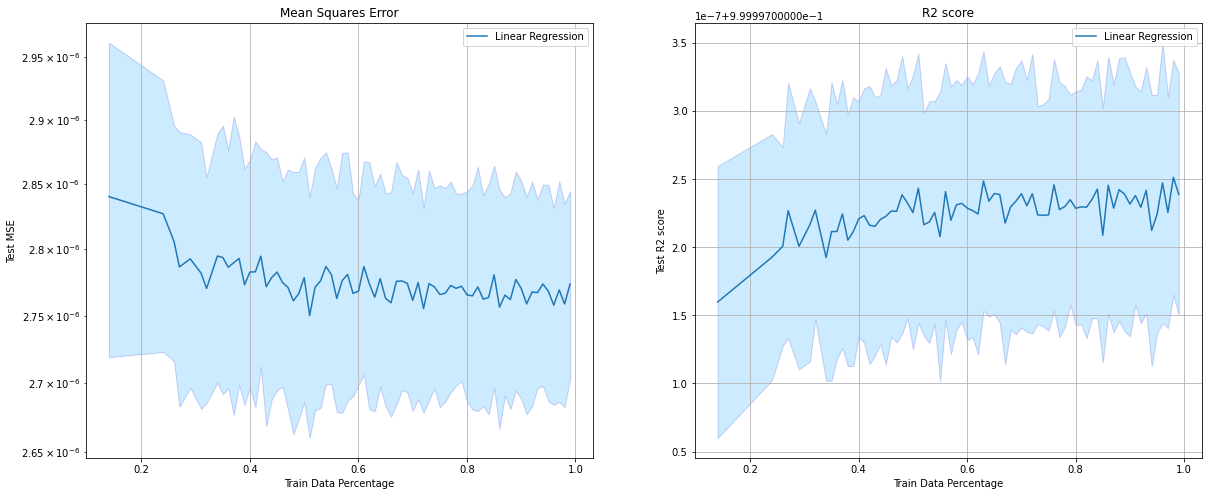

In [9]:
from pathlib import Path

path = Path('./results/neural_network')

mses = np.array(mses)
r2_scores = np.array(r2_scores)

#mses = np.load(path/'linear_reg_mses_var_percentage.npy')
#r2_scores = np.load(path/'linear_reg_scores_var_percentage.npy')

#np.save(path/'linear_reg_mses_var_percentage', mses)
#np.save(path/'linear_reg_scores_var_percentage', r2_scores)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Mean Squares Error")
plt.xlabel("Train Data Percentage")
plt.ylabel("Test MSE")
plt.grid(True)

final_mses = np.mean(mses, axis=0)
mses_error = np.std(mses, axis=0)

# remove the fucky percentages
rows = np.abs(final_mses) < 10000
final_mses_chosen = final_mses[rows][2:]
mses_error_chosen = mses_error[rows][2:]
percentages_chosen = percentages[rows][2:]

plt.semilogy(percentages_chosen, final_mses_chosen, label='Linear Regression')
plt.legend()
plt.fill_between(percentages_chosen, final_mses_chosen - mses_error_chosen, final_mses_chosen + mses_error_chosen, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')

plt.subplot(1, 2, 2)
plt.title("R2 score")
plt.xlabel("Train Data Percentage")
plt.ylabel("Test R2 score")
plt.grid(True)
plt.yscale('linear')

final_r2_score = np.mean(r2_scores, axis=0)
r2_score_error = np.std(r2_scores, axis=0)

# remove fucky values
r2_rows = np.abs(final_r2_score) < 10000
final_r2_score_chosen = final_r2_score[r2_rows][2:]
r2_score_error_chosen = r2_score_error[r2_rows][2:]
r2_percentages_chosen = percentages[r2_rows][2:]

plt.plot(r2_percentages_chosen, final_r2_score_chosen, label='Linear Regression')
plt.legend()
plt.fill_between(r2_percentages_chosen, final_r2_score_chosen - r2_score_error_chosen, final_r2_score_chosen + r2_score_error_chosen, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')

#### Performances wrt. added noise on training data

In [20]:
X_train, y_train, X_test, y_test = get_train_data(
    dataset,
    targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
    random_state=20943,
    as_numpy=False,
    validation=False
)

print(X_train.columns)
print(X_train['Zero_point_energy_(kcal/mol@0K)'])

Index(['Zero_point_energy_(kcal/mol@0K)', 'Enthalpy_(kcal/mol@298K)',
       'Gibbs_energy_(kcal/mol@298K)', '[', ''', '#', ' ', '(', ')', '+', '-',
       '/', '1', '2', '3', '4', '=', '@', 'B', 'C', 'F', 'H', 'I', 'N', '\n',
       'O', 'P', 'S', '\', ']', 'c', 'l', 'n', 'o', 'r', 's'],
      dtype='object')
3681      34.715581
17839     27.699422
23621     77.233062
9287      82.089287
27183     15.570562
            ...    
13841     82.204821
25689    115.747245
32425     74.889776
25879     68.192941
30529     37.294858
Name: Zero_point_energy_(kcal/mol@0K), Length: 9750, dtype: float64


In [22]:
noisy_mses = [[] for _ in range(N_TRIALS)]
noisy_r2_scores = [[] for _ in range(N_TRIALS)]
scale_factors = np.arange(0.1, 3, 0.1)

for k in range(N_TRIALS):
    for scale_factor in scale_factors:
        seed = random.randint(0, 10000)
        random_state = np.random.RandomState(seed)
        
        X_train, y_train, X_test, y_test = get_train_data(
            dataset,
            targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
            random_state=random_state,
            as_numpy=False,
            validation=False
        )
        
        features_scaler = StandardScaler()
        target_scaler = StandardScaler()
        lr = LinearRegression()

        # add noise to the first three columns which are our continuous features.
        X_train['Zero_point_energy_(kcal/mol@0K)'] += np.random.normal(scale=scale_factor*np.std(X_train['Zero_point_energy_(kcal/mol@0K)']), size=X_train.shape[0])
        X_train['Enthalpy_(kcal/mol@298K)'] += np.random.normal(scale=scale_factor*np.std(X_train['Enthalpy_(kcal/mol@298K)']), size=X_train.shape[0])
        X_train['Gibbs_energy_(kcal/mol@298K)'] += np.random.normal(scale=scale_factor*np.std(X_train['Gibbs_energy_(kcal/mol@298K)']), size=X_train.shape[0])

        lr.fit(features_scaler.fit_transform(X_train), target_scaler.fit_transform(y_train))
        y_pred = lr.predict(features_scaler.transform(X_test))
        
        noisy_mses[k].append(mean_squared_error(target_scaler.transform(y_test), y_pred))
        noisy_r2_scores[k].append(r2_score(target_scaler.transform(y_test), y_pred))

(100, 29)


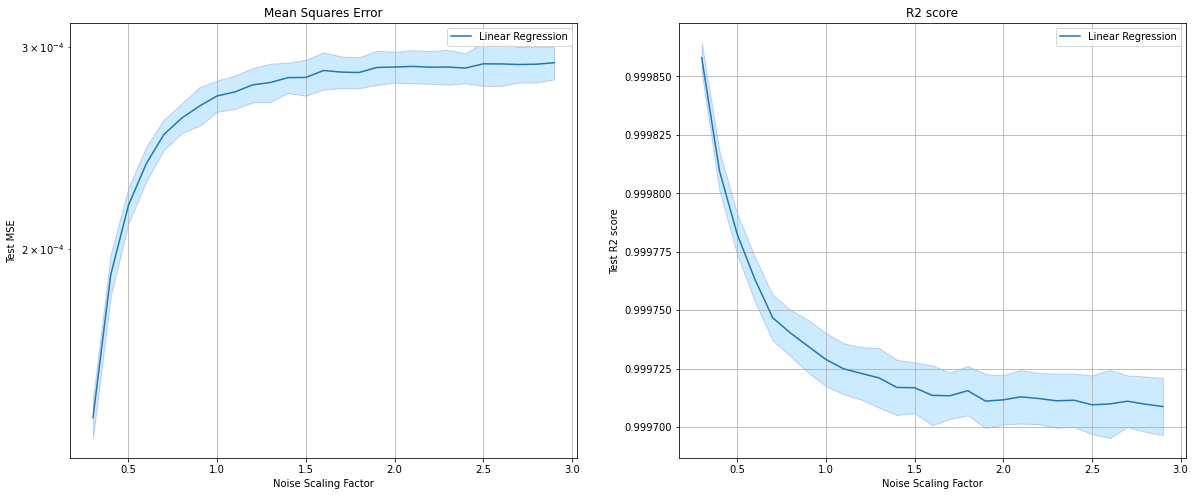

In [32]:
path = Path('./results/linear_regression')

noisy_mses = np.array(noisy_mses)
noisy_r2_scores = np.array(noisy_r2_scores)

noisy_mses = np.load(path/'linear_reg_mses_var_noisy.npy')
noisy_r2_scores = np.load(path/'linear_reg_scores_var_noisy.npy')

#np.save(path/'linear_reg_mses_var_noisy', noisy_mses)
#np.save(path/'linear_reg_scores_var_noisy', noisy_r2_scores)

print(noisy_mses.shape)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Mean Squares Error")
plt.xlabel("Noise Scaling Factor")
plt.ylabel("Test MSE")
plt.grid(True)

noisy_final_mses = np.mean(noisy_mses, axis=0)
noisy_mses_error = np.std(noisy_mses, axis=0)

# remove the fucky percentages
noisy_rows = np.abs(noisy_final_mses) < 10000
noisy_final_mses_chosen = noisy_final_mses[noisy_rows][2:]
noisy_mses_error_chosen = noisy_mses_error[noisy_rows][2:]
scale_factors_chosen = scale_factors[noisy_rows][2:]

plt.semilogy(scale_factors_chosen, noisy_final_mses_chosen, label='Linear Regression')
plt.legend()
plt.fill_between(
    scale_factors_chosen, 
    noisy_final_mses_chosen - noisy_mses_error_chosen, 
    noisy_final_mses_chosen + noisy_mses_error_chosen, 
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')

plt.subplot(1, 2, 2)
plt.title("R2 score")
plt.xlabel("Noise Scaling Factor")
plt.ylabel("Test R2 score")
plt.grid(True)
plt.yscale('linear')

noisy_final_r2_score = np.mean(noisy_r2_scores, axis=0)
noisy_r2_score_error = np.std(noisy_r2_scores, axis=0)

# remove fucky values
noisy_r2_rows = np.abs(noisy_final_r2_score) < 10000
noisy_final_r2_score_chosen = noisy_final_r2_score[noisy_r2_rows][2:]
noisy_r2_score_error_chosen = noisy_r2_score_error[noisy_r2_rows][2:]
noisy_r2_factors_chosen = scale_factors[noisy_r2_rows][2:]

plt.plot(noisy_r2_factors_chosen, noisy_final_r2_score_chosen, label='Linear Regression')
plt.legend()
plt.fill_between(
    noisy_r2_factors_chosen, 
    noisy_final_r2_score_chosen - noisy_r2_score_error_chosen, 
    noisy_final_r2_score_chosen + noisy_r2_score_error_chosen, 
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')
